# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.406207
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
With random initial weights, the log-likelihood for each class is expected to be the same. So -log(1/N) = -log(0.1)

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.097083 analytic: 1.097083, relative error: 6.309286e-08
numerical: 1.839339 analytic: 1.839339, relative error: 3.284557e-08
numerical: -2.608125 analytic: -2.608125, relative error: 1.144416e-08
numerical: -0.678083 analytic: -0.678083, relative error: 2.030964e-08
numerical: -0.157040 analytic: -0.157040, relative error: 1.206246e-07
numerical: -1.392941 analytic: -1.392941, relative error: 4.116706e-08
numerical: -1.118204 analytic: -1.118205, relative error: 5.799107e-08
numerical: 0.015356 analytic: 0.015356, relative error: 2.487563e-07
numerical: -3.380176 analytic: -3.380176, relative error: 2.410143e-08
numerical: -0.426807 analytic: -0.426807, relative error: 1.599080e-08
numerical: 1.003528 analytic: 1.003528, relative error: 2.055234e-08
numerical: 0.156626 analytic: 0.156626, relative error: 5.615658e-08
numerical: -3.766693 analytic: -3.766693, relative error: 1.938506e-09
numerical: -4.343860 analytic: -4.343860, relative error: 1.459487e-08
numerical: -0.15

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.406207e+00 computed in 0.128294s
vectorized loss: 2.406207e+00 computed in 0.005755s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]

learning_rates = np.log10([1e-7, 5e-6])
regularization_strengths = np.log10([5e3, 6e4])

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

#just copied from svm...
#num_params = 100
num_params=50
range_lr = np.logspace(learning_rates[0],learning_rates[1],num_params)
range_reg = np.logspace(regularization_strengths[0],regularization_strengths[1],num_params)

range_lr = range_lr[np.random.permutation(num_params)]
range_reg = range_reg[np.random.permutation(num_params)]

for learning_rate, regularization_strength in zip(range_lr, range_reg):
    #train
    print("Starting iteration with rate %e and regstrength %e"%(learning_rate,regularization_strength))
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                              num_iters=500, verbose=True)
    
    y_train_pred = softmax.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_acc)
    y_val_pred = softmax.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_acc)
    print('\n')
    
    results[(learning_rate,regularization_strength)]=(train_acc,val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_softmax = softmax


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Starting iteration with rate 2.221921e-07 and regstrength 1.184077e+04
iteration 0 / 500: loss 367.951608
iteration 100 / 500: loss 127.808815
iteration 200 / 500: loss 45.372869
iteration 300 / 500: loss 17.201688
iteration 400 / 500: loss 7.276234
training accuracy: 0.342878
validation accuracy: 0.352000


Starting iteration with rate 2.823236e-07 and regstrength 6.778204e+03
iteration 0 / 500: loss 214.427396
iteration 100 / 500: loss 98.630444
iteration 200 / 500: loss 46.565802
iteration 300 / 500: loss 22.562790
iteration 400 / 500: loss 11.479858
training accuracy: 0.342857
validation accuracy: 0.356000


Starting iteration with rate 5.791657e-07 and regstrength 2.289250e+04
iteration 0 / 500: loss 693.481730
iteration 100 / 500: loss 5.251391
iteration 200 / 500: loss 2.118454
iteration 300 / 500: loss 2.130144
iteration 400 / 500: loss 2.086588
training accuracy: 0.324020
validation accuracy: 0.332000


Starting iteration with rate 1.771018e-06 and regstrength 1.868946e+04
ite

iteration 400 / 500: loss 2.003830
training accuracy: 0.350612
validation accuracy: 0.347000


Starting iteration with rate 3.633110e-06 and regstrength 1.016969e+04
iteration 0 / 500: loss 316.610252
iteration 100 / 500: loss 2.081474
iteration 200 / 500: loss 1.998987
iteration 300 / 500: loss 2.123014
iteration 400 / 500: loss 2.043975
training accuracy: 0.323592
validation accuracy: 0.320000


Starting iteration with rate 3.354329e-06 and regstrength 1.605183e+04
iteration 0 / 500: loss 498.916382
iteration 100 / 500: loss 2.197705
iteration 200 / 500: loss 2.138612
iteration 300 / 500: loss 2.088139
iteration 400 / 500: loss 2.057069
training accuracy: 0.317980
validation accuracy: 0.317000


Starting iteration with rate 3.057877e-07 and regstrength 2.176051e+04
iteration 0 / 500: loss 681.890944
iteration 100 / 500: loss 48.230470
iteration 200 / 500: loss 5.254600
iteration 300 / 500: loss 2.361412
iteration 400 / 500: loss 2.054361
training accuracy: 0.335020
validation accurac

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.369000


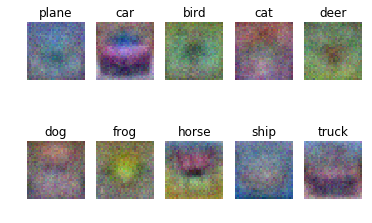

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])